In [10]:
import sys
print(sys.executable)

import torch
import math
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
import time
from numpy import genfromtxt

from matplotlib import style
style.use('seaborn-white')
#torch.cuda.empty_cache()

#gpytorch.settings.max_cg_iterations(2000)

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/belal/anaconda3/envs/pytorch/bin/python
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt):
    theta_dd = ((m1+m2)*gravity*np.sin(theta)-np.cos(theta)*(force+m2*length*(theta_d**2)*np.sin(theta)-mu_c*x_d)-((m1+m2)*mu_p*theta_d)/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(np.cos(theta))**2)
    x_dd = (force-m2*length*(theta_dd*np.cos(theta)-(theta_d**2)*np.sin(theta))-mu_c*x_d) / (m1+m2)
    # Euler Integrator 
    x_d = x_d + x_dd*dt
    x = x + x_d*dt
    theta_d = theta_d + theta_dd*dt
    theta = theta + theta_d*dt
    return theta_dd, theta_d, theta, x_dd, x_d,  x 

In [12]:
# Uncertainty Sources 
m1 = 1 
m2 = 0.1
length = 0.5
k_inertia = 1/3
mu_c = 0.0005
mu_p = 0.000002
gravity = 9.8 
dt = 0.01

# Initialization 
theta = 0.3 # np.random.uniform(low=-0.05, high=0.05)
theta_d = 1 # np.random.uniform(low=-0.05, high=0.05)
x = 0 # np.random.uniform(low=-0.05, high=0.05)
x_d = 0 # np.random.uniform(low=-0.05, high=0.05)

# lists for storing results 
theta_dd_sim = []
theta_d_sim = [theta_d]
theta_sim = [theta]
x_dd_sim = []
x_d_sim = [x_d]
x_sim = [x]

noOfSteps = 12000
ts = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

for i in range(noOfSteps):
    force = 0.5*np.sin(6*ts[i]) #-0.2+
    #force = -1+np.sin(ts[i])+3*np.sin(2*ts[i])
    #force = -0.5+0.2*np.sin(ts[i])+0.3*np.sin(2*ts[i])
    theta_dd, theta_d, theta, x_dd, x_d, x = cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt)
    theta_dd_sim.append(theta_dd)
    theta_d_sim.append(theta_d)
    theta_sim.append(theta)
    x_dd_sim.append(x_dd)
    x_d_sim.append(x_d)
    x_sim.append(x)

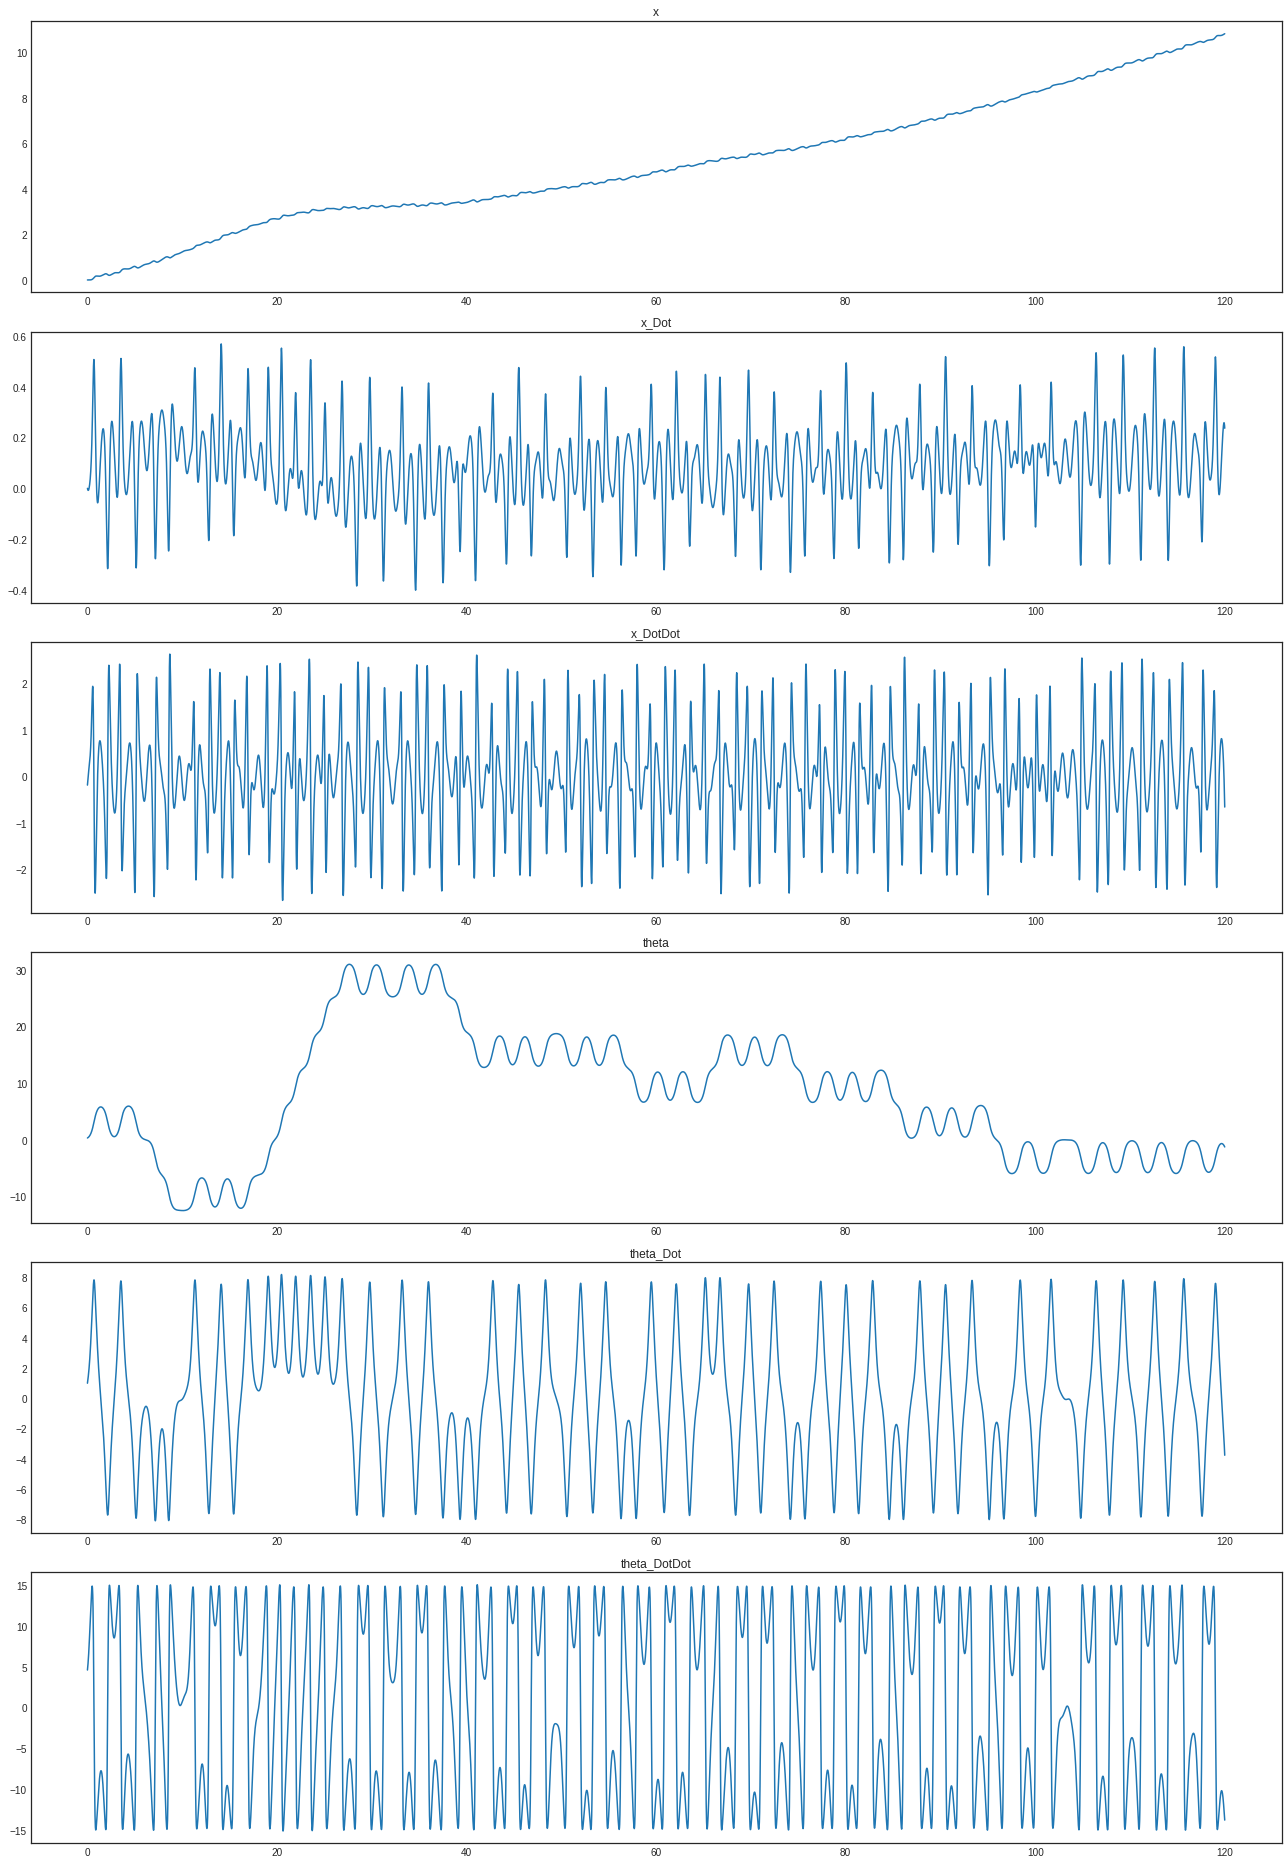

In [13]:
# Converting to Numpy Arrays for Plotting
theta_dd_sim = np.array(theta_dd_sim)
theta_d_sim = np.array(theta_d_sim)
theta_sim = np.array(theta_sim)
x_dd_sim = np.array(x_dd_sim)
x_d_sim = np.array(x_d_sim)
x_sim = np.array(x_sim)

timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

startTraj = 0
endTraj = 12000

# Plotting 
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.plot(timeSteps[startTraj:endTraj], x_sim[startTraj:endTraj])
ax1.set_title("x")
ax2.plot(timeSteps[startTraj:endTraj], x_d_sim[startTraj:endTraj])
ax2.set_title("x_Dot")
ax3.plot(timeSteps[startTraj:endTraj], x_dd_sim[startTraj:endTraj])
ax3.set_title("x_DotDot")
#axs[1, 0].sharex(axs[0, 0])
ax4.plot(timeSteps[startTraj:endTraj], theta_sim[startTraj:endTraj])
ax4.set_title("theta")
ax5.plot(timeSteps[startTraj:endTraj], theta_d_sim[startTraj:endTraj])
ax5.set_title("theta_Dot")
ax6.plot(timeSteps[startTraj:endTraj], theta_dd_sim[startTraj:endTraj])
ax6.set_title("theta_DotDot")
fig.tight_layout()

Text(0.5, 1.0, 'A single plot')

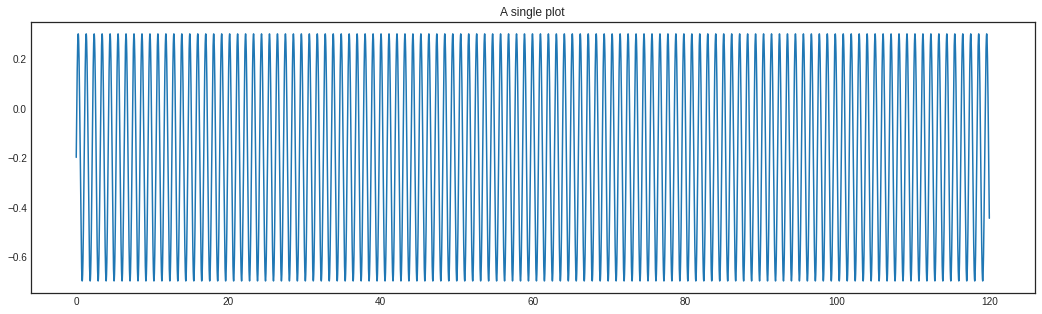

In [5]:
# Force Input Plot 
forceIn = -0.2+0.5*np.sin(6*timeSteps)
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(18)

ax.plot(timeSteps[startTraj:endTraj], forceIn[startTraj:endTraj])
ax.set_title('A single plot')

In [6]:
st_Traj = 0
en_Traj = 8000 # 2307 # 9405

# Training Input (Standardized)
theta_sim_mean = theta_sim[st_Traj:en_Traj].mean()
theta_sim_stdev = theta_sim[st_Traj:en_Traj].std()

theta_d_sim_mean = theta_d_sim[st_Traj:en_Traj].mean()
theta_d_sim_stdev = theta_d_sim[st_Traj:en_Traj].std()

x_d_sim_mean = x_d_sim[st_Traj:en_Traj].mean()
x_d_sim_stdev = x_d_sim[st_Traj:en_Traj].std()

forceIn_mean = forceIn[st_Traj:en_Traj].mean()
forceIn_stdev = forceIn[st_Traj:en_Traj].std()  

# Training Output (Standardized)
theta_dd_sim_mean = theta_dd_sim[st_Traj:en_Traj].mean()
theta_dd_sim_stdev = theta_dd_sim[st_Traj:en_Traj].std()  

x_dd_sim_mean = x_dd_sim[st_Traj:en_Traj].mean()
x_dd_sim_stdev = x_dd_sim[st_Traj:en_Traj].std() 

X_train = np.stack(((theta_sim[st_Traj:en_Traj]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[st_Traj:en_Traj]-forceIn_mean)/forceIn_stdev), axis=1)

Y_train_theta_dd = ((theta_dd_sim[st_Traj:en_Traj]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_train_x_dd = ((x_dd_sim[st_Traj:en_Traj]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)
Y_train_theta_d = ((theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev)  # RMSE(V)
Y_train_x_d = ((x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev)  # RMSE(V)

Y_train = np.stack((Y_train_theta_dd, Y_train_x_dd, Y_train_theta_d, Y_train_x_d), axis=1) # For MultiOutput GP

# Testing Output (Standardized)

Y_test_theta_dd = ((theta_dd_sim[en_Traj:]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_test_x_dd = ((x_dd_sim[en_Traj:]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)
Y_test_theta_d = ((theta_d_sim[en_Traj:]-theta_d_sim_mean)/theta_d_sim_stdev)  # RMSE(V)
Y_test_x_d = ((x_d_sim[en_Traj:]-x_d_sim_mean)/x_d_sim_stdev)  # RMSE(V)

X_prior = np.stack(((theta_sim[:-1]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[:-1]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[:-1]-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

In [7]:
# Numpy to tensors 
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_prior = torch.from_numpy(X_prior).float()

# Putting tensors on GPU
X_train = X_train.cuda()
Y_train = Y_train.cuda()
X_prior = X_prior.cuda()

# MultiOutput GP

In [8]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=4
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=4), num_tasks=4, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=4, noise_constraint=gpytorch.constraints.GreaterThan(0.002))
#noise_prior=gpytorch.priors.SmoothedBoxPrior(0.15, 1.5, sigma=0.001))
model = MultitaskGPModel(X_train, Y_train, likelihood)

# putting on GPU
model = model.cuda()
likelihood = likelihood.cuda()

In [17]:
# Find optimal model hyperparameters
training_iter = 2000

model.train()
likelihood.train()

noiseTrain = np.zeros(training_iter)
lossTrain = np.zeros(training_iter)

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

start_time = time.time()

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    noiseTrain[i] = model.likelihood.noise.item()
    lossTrain[i] = loss.item()
    optimizer.step()
    
print('Total time is %s:' %(time.time() - start_time))     

Iter 1/2000 - Loss: 1.197  noise: 0.695
Iter 2/2000 - Loss: 1.193  noise: 0.690
Iter 3/2000 - Loss: 1.189  noise: 0.685
Iter 4/2000 - Loss: 1.186  noise: 0.680
Iter 5/2000 - Loss: 1.182  noise: 0.675
Iter 6/2000 - Loss: 1.178  noise: 0.670
Iter 7/2000 - Loss: 1.175  noise: 0.666
Iter 8/2000 - Loss: 1.171  noise: 0.661
Iter 9/2000 - Loss: 1.167  noise: 0.656
Iter 10/2000 - Loss: 1.164  noise: 0.651
Iter 11/2000 - Loss: 1.160  noise: 0.646
Iter 12/2000 - Loss: 1.156  noise: 0.642
Iter 13/2000 - Loss: 1.153  noise: 0.637
Iter 14/2000 - Loss: 1.149  noise: 0.632
Iter 15/2000 - Loss: 1.145  noise: 0.628
Iter 16/2000 - Loss: 1.142  noise: 0.623
Iter 17/2000 - Loss: 1.138  noise: 0.618
Iter 18/2000 - Loss: 1.134  noise: 0.614
Iter 19/2000 - Loss: 1.130  noise: 0.609
Iter 20/2000 - Loss: 1.127  noise: 0.604
Iter 21/2000 - Loss: 1.123  noise: 0.600
Iter 22/2000 - Loss: 1.119  noise: 0.595
Iter 23/2000 - Loss: 1.115  noise: 0.591
Iter 24/2000 - Loss: 1.112  noise: 0.586
Iter 25/2000 - Loss: 1.10

In [18]:
# save models 
#torch.save(model.state_dict(), '../../learnedModels/deterministicCase/GPwithGPyTorch/multi_RBF_gpytorch_Noise(0.002)Rank(1)Iter(2k)Train(8k)ForceIn')
#torch.save(model.state_dict(), '../../learnedModels/deterministicCase/GPwithGPyTorch/multi_RBF_gpytorch_Noise(0.002)Rank(1)Iter(2k)Train(8k)1')

In [9]:
# Get into evaluation (predictive posterior) mode

model.load_state_dict(torch.load('../../learnedModels/deterministicCase/GPwithGPyTorch/multi_RBF_gpytorch_Noise(0.002)Rank(1)Iter(2k)Train(8k)ForceIn'))

model.eval()
likelihood.eval()

sim_iter = 4500 

mean = np.zeros((sim_iter,4))
lower = np.zeros((sim_iter,4))
upper = np.zeros((sim_iter,4))

start_time = time.time()

# , gpytorch.settings.fast_pred_var()
with torch.no_grad():
    for i in range(sim_iter):
        observed_pred = likelihood(model(X_prior[i+6500,:].reshape(1,-1)))
        if i%200==0:
            print(i)
        interMean = observed_pred.mean
        mean[i,:] = interMean.cpu().numpy()
        interLow, interUp = observed_pred.confidence_region()
        lower[i,:], upper[i,:] = interLow.cpu().numpy(), interUp.cpu().numpy()
        torch.cuda.empty_cache()
        
print('Total time is %s:' %(time.time() - start_time))          

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
Total time is 9939.969433307648:


In [9]:
# Get into evaluation (predictive posterior) mode

#model.load_state_dict(torch.load('../../learnedModels/deterministicCase/GPwithGPyTorch/multi_RBF_gpytorch_Noise(0.002)Rank(1)Iter(2k)Train(8k)1'))

#model.eval()
#likelihood.eval()

# , gpytorch.settings.fast_pred_var()
#with torch.no_grad(), gpytorch.settings.fast_pred_var():
#        observed_pred = likelihood(model(X_prior))

In [37]:
allData = np.stack((mean[:,0], lower[:,0], upper[:,0], mean[:,1], lower[:,1], upper[:,1], mean[:,2], lower[:,2], upper[:,2],
                    mean[:,3], lower[:,3], upper[:,3]), axis=1)
np.savetxt('MultiOutGPwithPytorchForceIn.csv', allData, delimiter=',')

In [10]:
# Putting back on CPU
X_train = X_train.cpu()
Y_train = Y_train.cpu()
X_prior = X_prior.cpu()

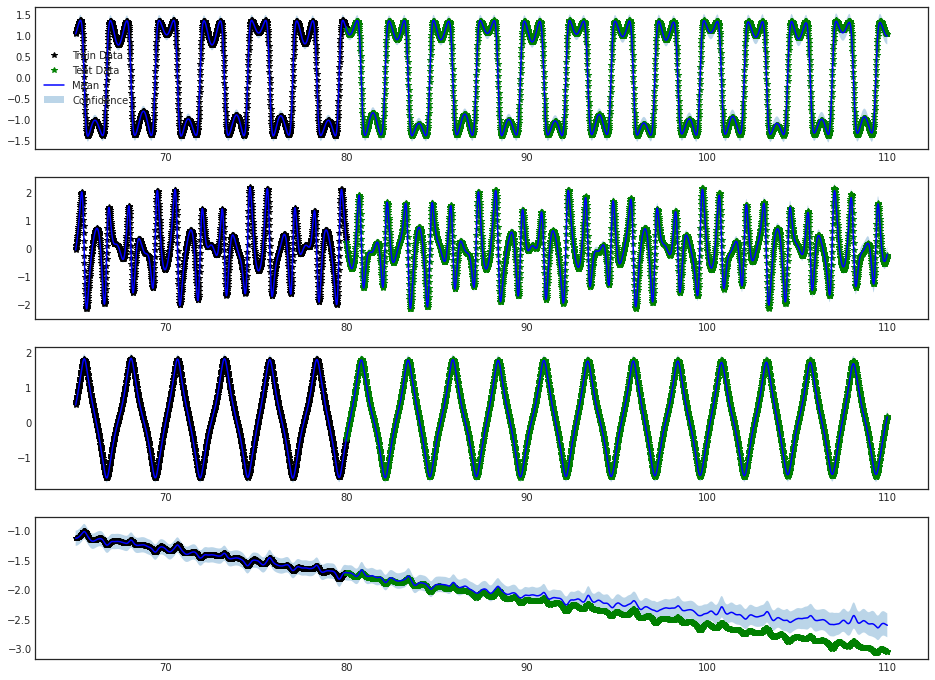

In [38]:
star_Traj = 6500
mids_Traj = 8000
ends_Traj = 11000

# Reading form saved csv file 
meanPred = np.zeros((mean[:,0].shape[0],4)) 
lowerPred = np.zeros((lower[:,0].shape[0],4))
upperPred = np.zeros((upper[:,0].shape[0],4)) 

my_data = genfromtxt('MultiOutGPwithPytorchForceIn.csv', delimiter=',')
meanPred[:,0] = my_data[:,0]
lowerPred[:,0] = my_data[:,1]
upperPred[:,0] = my_data[:,2]

meanPred[:,1] = my_data[:,3]
lowerPred[:,1] = my_data[:,4]
upperPred[:,1] = my_data[:,5]

meanPred[:,2] = my_data[:,6]
lowerPred[:,2] = my_data[:,7]
upperPred[:,2] = my_data[:,8]

meanPred[:,3] = my_data[:,9]
lowerPred[:,3] = my_data[:,10]
upperPred[:,3] = my_data[:,11]

# Initialize plot
fig, ax = plt.subplots(4)

fig.set_figheight(12)
fig.set_figwidth(16)

# Get upper and lower confidence bounds
ax[0].plot(timeSteps[star_Traj:mids_Traj], Y_train_theta_dd[star_Traj:], 'k*')
ax[0].plot(timeSteps[mids_Traj:ends_Traj], Y_test_theta_dd[:ends_Traj-mids_Traj], 'g*')
ax[0].plot(timeSteps[star_Traj:ends_Traj], meanPred[:,0], 'b')
# Shade between the lower and upper confidence bounds
ax[0].fill_between(timeSteps[star_Traj:ends_Traj], lowerPred[:,0], upperPred[:,0], alpha=0.3)
#ax.set_ylim([-3, 3])
ax[0].legend(['Train Data', 'Teat Data', 'Mean' , 'Confidence'])

# Get upper and lower confidence bounds
ax[1].plot(timeSteps[star_Traj:mids_Traj], Y_train_x_dd[star_Traj:], 'k*')
ax[1].plot(timeSteps[mids_Traj:ends_Traj], Y_test_x_dd[:ends_Traj-mids_Traj], 'g*')
ax[1].plot(timeSteps[star_Traj:ends_Traj], meanPred[:,1], 'b')
# Shade between the lower and upper confidence bounds
ax[1].fill_between(timeSteps[star_Traj:ends_Traj], lowerPred[:,1], upperPred[:,1], alpha=0.3)
#ax.set_ylim([-3, 3])

# Get upper and lower confidence bounds
ax[2].plot(timeSteps[star_Traj:mids_Traj], Y_train_theta_d[star_Traj:], 'k*')
ax[2].plot(timeSteps[mids_Traj:ends_Traj], Y_test_theta_d[:ends_Traj-mids_Traj], 'g*')
ax[2].plot(timeSteps[star_Traj:ends_Traj], meanPred[:,2], 'b')
# Shade between the lower and upper confidence bounds
ax[2].fill_between(timeSteps[star_Traj:ends_Traj], lowerPred[:,2], upperPred[:,2], alpha=0.3)
#ax.set_ylim([-3, 3])

# Get upper and lower confidence bounds
ax[3].plot(timeSteps[star_Traj:mids_Traj], Y_train_x_d[star_Traj:], 'k*')
ax[3].plot(timeSteps[mids_Traj:ends_Traj], Y_test_x_d[:ends_Traj-mids_Traj], 'g*')
ax[3].plot(timeSteps[star_Traj:ends_Traj], meanPred[:,3], 'b')
# Shade between the lower and upper confidence bounds
ax[3].fill_between(timeSteps[star_Traj:ends_Traj], lowerPred[:,3], upperPred[:,3], alpha=0.3)
#ax.set_ylim([-3, 3])
#plt.savefig('multi_RBF_gpytorch_Noise(0.002)Rank(1)Iter(2k)Train(8k)1.png')

# Loss Plot

/mnt/bgfs/belal/4200561/ipykernel_18662/2055061924.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-white')


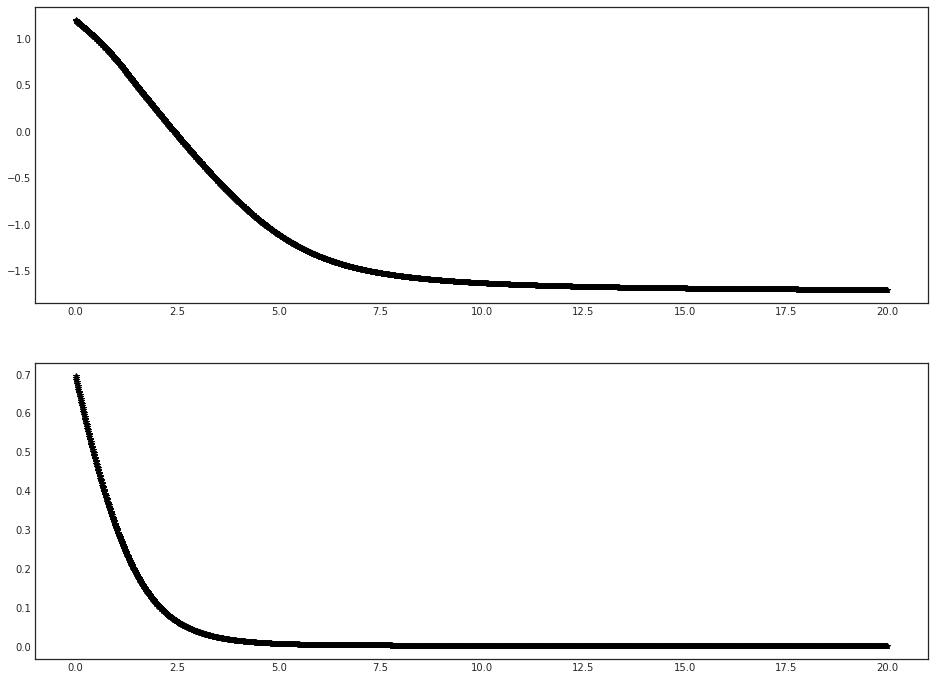

In [22]:
style.use('seaborn-white')

star_Traj = 0
mids_Traj = 4000
ends_Traj = 4300

# Initialize plot
fig, ax = plt.subplots(2)

fig.set_figheight(12)
fig.set_figwidth(16)

ax[0].plot(timeSteps[:training_iter], lossTrain, 'k*')
ax[1].plot(timeSteps[:training_iter], noiseTrain, 'k*')
plt.savefig('multi_RBF_gpytorch_Noise(0.002)Rank(1)Iter(2k)Train(8k)1.png')